Датасет отзывов в банк содержит произвольный стиль написания городов. Это создает проблему, что в списке может быть множество вариантов написания города и правильно рассортировать отзывы и посчитать их не предоставляется возможным. 

Для решения этой задачи можно использовать алгоритм "Цепь Маркова".
Далее приведен пример такого алгоритма адаптированный для подбора правильного города.

Для начала был сформирован список городов с сайта wikipedia, он расположен в директории /dicts/, с названием - russian-cities.json.
Далее был произведен отбор всех вариантов написания городов без повторений и размещен в директории /prepare/, с названием - distinct_cities.csv.
После чего можно произвести подбор алгоритмом цепи Маркова. Принцип заключается в записи матрицы близости на основе эталонного названия города и дальнейшее сравнение последовательностей угадываемого города с эталонной матрицей. Далее отрисована матрица близости для г. Краснодар, другие матрицы записаны в карту.

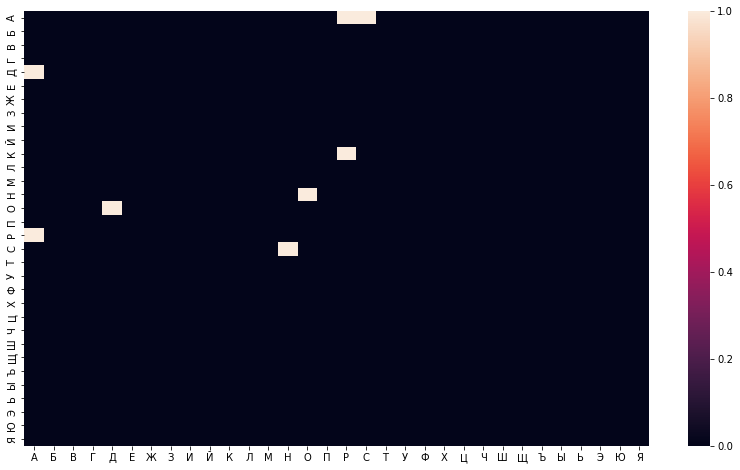

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re
import bz2
from tqdm import tqdm
import json

df_cities = pd.read_json('./dicts/russian-cities.json')
cities = df_cities['name'].values

city_probabilities = {}

for city in cities:
    city = re.sub("[^А-Яа-я]","",city)
    city = re.sub("[Ё]","Е",city)
    city = city.upper()
    
    RUSSIAN = "АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ"
    POS = {l: i for i, l in enumerate(RUSSIAN)}
    probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))
       
    def split(s):
        return [char for char in s]
         
    if (len(city)>1):
        for cp, cn in zip(city[:-1], city[1:]):
            probabilities[POS[cp], POS[cn]] += 1
    
    city_probabilities[city] = probabilities


df = pd.DataFrame(city_probabilities["КРАСНОДАР"], index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

Выше изображена эталонная матрица близости для одного города.

Далее произведено чтение всех вариантов написания городов и поиск в эталонных матрицах.
Алгоритм заключается в итерационном чтении пар букв со смещением в одну букву и поиске соответствующих пар в эталонной матрице, с начислением бала при совпадении.
Результаты поисков записаны в директории /watch_data/, файл - cities_probabilities.csv.

In [ ]:
def stand(text):
    text = text.upper()
    text = re.sub(r'\(.+\)', '', text)
    text = text.replace("Г.", "")
    text = text.replace("Ё", "Е")
    text = re.sub("[.|,|!|?| |-]","",text)
    text = re.sub("[^А-Я]","",text)
    return text

find_dict = {}
with open('./prepare/distinct_cities.csv', encoding=('utf-8')) as file_obj:
    reader_obj = csv.reader(file_obj)
    for row in reader_obj:
        input_word = stand(row[0])
        find_dict[(input_word, row[0])] = []
        input_length = len(input_word)
        for city in city_probabilities.keys():
            score = 0
            count_bigram = 0
            probabilities_ = city_probabilities[city]
            for i in range(0, input_length, 1):
                if (i+1<input_length):
                    count_bigram+=1
                    first = input_word[i]
                    second = input_word[i+1]
                    proba = probabilities_[POS[first], POS[second]]
                    if (proba>0):
                        score = score + proba
            if ((count_bigram==2 and score==2) or (score>=3)):
                find_dict[(input_word, row[0])].append((city,score))
                
#with open('./watch_data/cities_probabilities.csv', 'w') as csv_file:
#    for key in find_dict:
#        csv_file.write(str(key))
#        csv_file.write("\t-\t")
#        csv_file.write(str(find_dict[key]))
#        csv_file.write('\n')

Далее произведен отбор результатов с наибольшим балом. Справочник записан - /dicts/cities_eq_dict.json

In [ ]:
def takeSecond(elem):
    return elem[1]

cities_eq_dict = {}
for (short, full) in find_dict.keys():
    length = len(short)
    cities_list = find_dict[(short, full)]
    if cities_list:
        cities_list.sort(key=takeSecond, reverse=True)
        cities_eq_dict[full] = cities_list[0][0]

#with open('./dicts/cities_eq_dict.json', 'w') as json_file:
#    json.dump(cities_eq_dict, json_file, indent=2, ensure_ascii=False)

Теперь, при имеющейся карте соответствий можно подсчитать кол-во отзывов до банков по городам, вывод представлен для Москвы.

In [3]:
import codecs

with codecs.open('./dicts/cities_eq_dict.json', "r", "utf_8_sig" ) as f:
    data = f.read()
cities_eq_dict = json.loads(data)

responses = []
with bz2.BZ2File('./input/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)
            
cities_banks_dict = {}
for resp in responses:
    f_name_city = resp['city']

    if f_name_city in cities_eq_dict:
        city = cities_eq_dict[f_name_city]
    else:
        city = "Unknown"
    
    bank_name = resp['bank_name']
    if (city in cities_banks_dict.keys()):
        if (bank_name in cities_banks_dict[city].keys()):
            cities_banks_dict[city][bank_name].append(resp)
        else:
            cities_banks_dict[city][bank_name] = [resp]
    else:
        banks_resp_dict = {}
        banks_resp_dict[bank_name] = [resp]
        cities_banks_dict[city] = banks_resp_dict
        
moscow_responces = cities_banks_dict["МОСКВА"]

city_set = set()
for bank_name in moscow_responces.keys():
    print(bank_name + " - " + str(len(moscow_responces[bank_name])))
    for bank_list in moscow_responces[bank_name]:
        city_set.add(bank_list['city'])

187229it [00:46, 4047.77it/s]


АйМаниБанк - 389
ВТБ 24 - 2506
ЮниКредит Банк - 1153
Сбербанк России - 7874
Яндекс.Деньги - 59
Московский Кредитный Банк - 2207
Совкомбанк - 308
Альфа-Банк - 3675
Русский Стандарт - 2673
Русфинанс Банк - 144
Банк Москвы - 1203
Росгосстрах Банк - 114
Хоум Кредит Банк - 2016
Тинькофф Банк - 2105
Национальный Банк «Траст» - 1617
Московский Областной Банк - 606
Бинбанк - 482
Ханты-Мансийский банк Открытие - 583
ОТП Банк - 658
Восточный Экспресс Банк - 344
Связной Банк - 1364
Сетелем Банк - 299
СМП Банк - 302
РосЕвроБанк - 160
Авангард - 1045
Югра - 206
Райффайзенбанк - 1407
Легион - 11
Росбанк - 552
МДМ Банк - 200
Промсвязьбанк - 1007
Океан Банк - 160
Москоммерцбанк - 61
Военно-Промышленный Банк - 85
МФБанк - 6
Лето Банк - 80
Ситибанк - 1101
Русский Торговый Банк - 23
Россельхозбанк - 73
Русславбанк - 246
Нордеа Банк - 139
Арксбанк - 60
БИНБАНК кредитные карты - 371
Русский Ипотечный Банк - 22
Смартбанк - 114
Уралсиб - 337
Интерпрогрессбанк - 36
Миръ - 29
Транскапиталбанк - 45
Ренессанс Кр

Выведем все варианты записи города Москва в отзывах.

In [4]:
print(city_set)

{'г. Москва (Московская обл.)', 'г. Москва (Санкт-Петербург)', 'г. Москва (Калининград)', 'г. Москва, Спб', 'г. Мосвква', 'г. Москва (прошло ЧЕТЫРЕ рабочих дня!)', 'г. Москва,', 'г. Москва (Нижний Новгород)', 'г. Москва и СПб', 'г. Москва, Ветошный пер', 'г. Москва (Тюменская область)', 'г. Москва/Тверь', 'г. Москва, Королёв', 'г. Москва (Химки)', 'г. Москва, Земляной вал, 7', 'г. Разань, Москва', 'г. г Москва', 'г. Москва видимо', 'г. Москва (Москва и область)', 'г. Москва (Мытищи)', 'г. СПб и Москва', 'г. Москва-Сочи', 'г. Москва  и  М.О.', 'г. Москва (отделение Полянка)', 'г. Мосева', 'г. москва (Санкт-Петербург)', 'г. Mосква', 'г. Тула и Москва', 'г. Питер-Москва', 'г. Москва (Уфа)', 'г. Москва (Зеленоград) (Москва)', 'г. Мытищи, Москва', 'г. Сочи, Москва', 'г. Москва', 'г. тула-москва', 'г. Москва (Москва)', 'г. Москва (Обнинск)', 'г. Москва (Новомосковск)', 'г. Мучкап(в начале), теперь Москва', 'г. Моссква', 'г. Москва (Тверь)', 'г. Москва, сейчас в Майами', 'г. Москва, Уфа', 'г.

Далее проведем обработку тексов отзывов, приведем все слова к леммам.
Запишем обработанные отзывы в файлы по 10000 штук, в директорию /after_process/.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import re
import nltk
from nltk.corpus import stopwords
import bz2
import json
from tqdm import tqdm
from pymystem3 import Mystem
import calendar
import time
import dis 

warnings.filterwarnings('ignore')
m = Mystem()

nltk.download('stopwords')

mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")

def words_only(text):
    return " ".join(ru_words.findall(text))

def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

rows_max = 10000
it_counter = 0
json_str = ""

def createResponsesFile(json_str):
    current_GMT = time.gmtime()
    timestamp = calendar.timegm(current_GMT)
    with bz2.open("./after_process/banks_responses_"+str(timestamp)+".json.bz2", "w") as writing_file:
        json_bytes = json_str.encode('utf-8')
        writing_file.write(json_bytes)
        writing_file.close()

with bz2.BZ2File('./input/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            it_counter+=1
            resp['text'] = preprocess(resp['text'])
            json_str = json_str + json.dumps(resp) + "\n"
            if (it_counter % rows_max) == 0:
                createResponsesFile(json_str)
                json_str = "" 
    #createResponsesFile(json_str)

Installing mystem to C:\Users\vladislav/.local/bin\mystem.exe from http://download.cdn.yandex.net/mystem/mystem-3.1-win-64bit.zip
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vladislav\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
261it [03:21,  1.02it/s]

Прочитаем файл и выведем 10 самых частых лем.

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
from os import listdir
from os.path import isfile, join
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk import ngrams
import numpy
nltk.download('punkt')
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression

source_dir = "./after_process/"
texts = []
resp_array = []
with bz2.BZ2File(source_dir+"banks_responses_1670583357.json.bz2", 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        resp_array.append(resp)
        if (len(resp['text'].split()) > 0):
            texts.append(resp['text'])

tokenizer = RegexpTokenizer(r"\w+")

tokenize_words = [tokenizer.tokenize(text.lower()) for text in tqdm(texts)]
concat_array = numpy.concatenate(tokenize_words, axis=0)

freq_dict = Counter(concat_array)
most_com = freq_dict.most_common(10)

for idx in most_com:
    print(idx)

"Сотрудник" встречается чаще чем "Клиент".
Далее построим кривые Ципфа и Хипса.

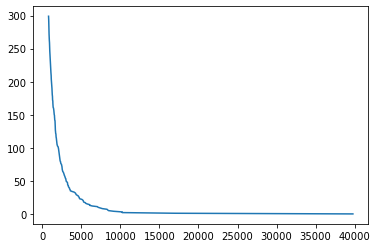

100%|██████████| 10000/10000 [00:02<00:00, 4873.22it/s]


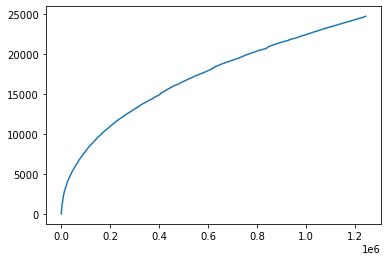

In [7]:
freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for text in tqdm(texts):
    tokens = tokenizer.tokenize(text.lower())
    cnt.update([token for token in tokens])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()


Построим матрицу близости

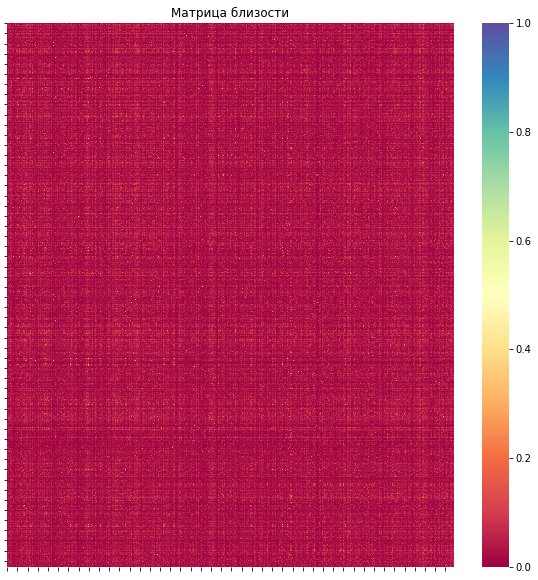

In [11]:
df = pd.DataFrame(resp_array)
df = df.dropna()
df = df.reset_index(drop=True) 

x_train, x_test, y_train, y_test = train_test_split(df.text, df.rating_grade)

from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))

from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

texts = [text.split() for text in df.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости")
plt.show()

Выведем 5 произвольных тем на основе лемм

In [12]:
from gensim.models import lsimodel
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)
print(lsi.show_topics(5))

[(0, '0.190*"карта" + 0.134*"вклад" + 0.126*"кредит" + 0.112*"деньги" + 0.111*"заявление" + 0.106*"счет" + 0.099*"сумма" + 0.099*"отделение" + 0.097*"платеж" + 0.093*"сотрудник"'), (1, '-0.474*"вклад" + 0.258*"кредит" + -0.240*"очередь" + 0.176*"платеж" + -0.173*"открывать" + 0.143*"страховка" + 0.142*"погашение" + 0.124*"задолженность" + -0.118*"операционист" + 0.112*"кредитный"'), (2, '0.349*"карта" + 0.297*"банкомат" + -0.295*"кредит" + -0.236*"вклад" + -0.232*"страховка" + -0.166*"договор" + -0.148*"страхование" + -0.133*"досрочный" + -0.131*"погашение" + 0.122*"операция"'), (3, '-0.299*"вклад" + -0.224*"банкомат" + 0.194*"карта" + -0.188*"сумма" + 0.169*"заявка" + -0.169*"руб" + -0.154*"средство" + -0.152*"платеж" + -0.141*"комиссия" + -0.139*"процент"'), (4, '0.321*"страховка" + 0.295*"карта" + 0.228*"страхование" + -0.204*"платеж" + -0.187*"терминал" + -0.156*"номер" + 0.149*"комиссия" + -0.147*"звонок" + 0.129*"услуга" + 0.129*"вклад"')]


In [ ]:
Сделаем обучающее множество из мешка слов и рейтинга 1 и 5

In [1]:
from sklearn.ensemble import RandomForestClassifier
import bz2
from tqdm import tqdm
import json
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

source_dir = "./after_process/"
texts = []
resp_array = []
#for file_bz2 in listdir(source_dir):
with bz2.BZ2File(source_dir+"banks_responses_1670583357.json.bz2", 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        resp_array.append(resp)
        if (len(resp['text'].split()) > 0):
            texts.append(resp['text'])


df = pd.DataFrame(resp_array)
df = df.dropna()
df = df.reset_index(drop=True) 


df = df.loc[(df['rating_grade'] == 1) | (df['rating_grade'] == 5)]
y = df.rating_grade

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(df.text).toarray()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vladislav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
10000it [00:02, 3623.84it/s]


Разделим на обучающее и тестовое множество и обучим модель случайного дерева

In [2]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfc=RandomForestClassifier(n_estimators=100)
rfc.fit(x_train, y_train)
predictions_rfc = rfc.predict(x_test)
print('RandomForestClassifier metrics:\n', classification_report(y_test, predictions_rfc))

RandomForestClassifier metrics:
               precision    recall  f1-score   support

         1.0       0.92      1.00      0.96       546
         5.0       0.98      0.54      0.70       106

    accuracy                           0.92       652
   macro avg       0.95      0.77      0.83       652
weighted avg       0.93      0.92      0.91       652



Далее проверим данную можель с использованием TFIDF

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X2 = tfidfconverter.fit_transform(X).toarray()

x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size=0.2)

rfc=RandomForestClassifier(n_estimators=100)
rfc.fit(x_train, y_train)
predictions_rfc = rfc.predict(x_test)
print('RandomForestClassifier TFIDF metrics:\n', classification_report(y_test, predictions_rfc))

RandomForestClassifier TFIDF metrics:
               precision    recall  f1-score   support

         1.0       0.92      1.00      0.96       545
         5.0       0.97      0.56      0.71       107

    accuracy                           0.92       652
   macro avg       0.94      0.78      0.83       652
weighted avg       0.93      0.92      0.92       652



In [ ]:
Для данной задачи показатели влияют на показатели recall и f1-score положительно